In [5]:
import numpy as np
import os, copy, time, json, cv2, random
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive
import torchvision.transforms as T
from torchsummary import summary

import detectron2
from detectron2        import model_zoo
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader, build_detection_train_loader
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from tqdm.notebook import tqdm, trange

import pandas as pd

# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

mz = _ModelZooUrls()
# print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

torch:  2.5 ; cuda:  cu124


In [6]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode, PolygonMasks

BATCH = 2

cfg = get_cfg()

model_config = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" # model - model_final.pth_3

cfg.merge_from_file(model_zoo.get_config_file(model_config))

cfg.DATASETS.TRAIN = ("stone_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 400    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth_3")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
#cfg.DATASETS.TEST = ("stone_valid")
predictor = DefaultPredictor(cfg)

/wdata/VENV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu")

In [5]:
CAT_ID_STONE = 2
CAT_ID_ASBEST = 1

BOX_COUNT_MIN = 1
USE_CAT_ID = CAT_ID_STONE

In [7]:
IPATH = 'gen_dataset'

/wdata/VENV/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


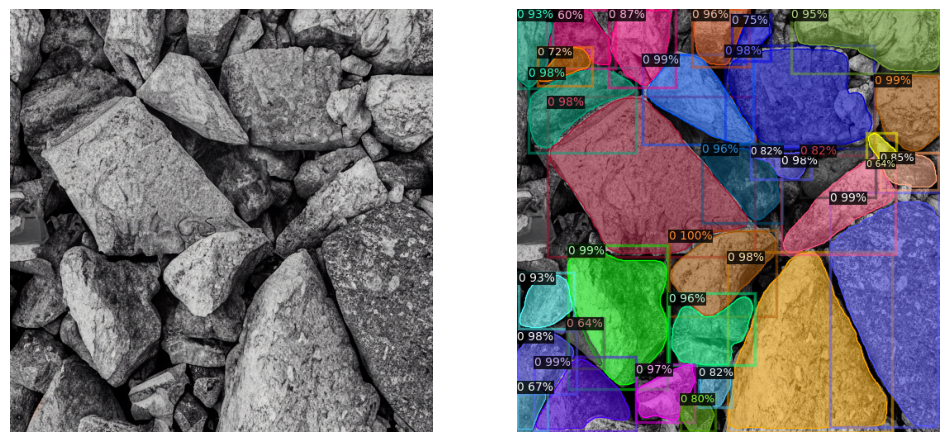

In [10]:
img   = cv2.imread(IPATH + '/image_1.png')
_,axs = plt.subplots(1,2,figsize=(12,8))
axs[0].imshow(img); axs[0].axis('off')

outputs = predictor(img)
# print(outputs)
v = Visualizer(img, 
                scale=1
              )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# plt.imsave('pred/' + d["file_name"], out.get_image())

axs[1].imshow(out.get_image())
axs[1].axis('off')
#print(outputs)
    
plt.show()

In [64]:
#!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.1 MB/s eta 0:00:0000:0100:010m


In [11]:
from shapely.geometry import Polygon, LineString

def simplify_segmentation(segmentation, tolerance=2.0):
    """
    Уменьшает количество точек в полигонах segmentation.
    :param segmentation: Список координат [x1, y1, x2, y2, ...].
    :param tolerance: Допустимая погрешность при упрощении.
    :return: Упрощённый список координат.
    """
    simplified_segmentation = []
    for polygon in segmentation:
        # Преобразуем в LineString
        line = LineString([(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)])
        # Упростим с заданной погрешностью
        simplified_line = line.simplify(tolerance, preserve_topology=True)
        # Преобразуем обратно в список координат
        simplified_coords = []
        for coord in simplified_line.coords:
            simplified_coords.extend(coord)
        simplified_segmentation.append(simplified_coords)
    return simplified_segmentation


In [12]:
import os
import json
import cv2
from detectron2.utils.visualizer import GenericMask
from tqdm import tqdm


def process_images_and_save_in_coco_format(image_dir, predictor, output_json_path, tolerance=2.0):
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    
    # Категории модели (замените category_id и names на ваши)
    categories = [{"id": 1, "name": "stone"}]
    coco_format["categories"] = categories
    
    image_id = 1
    annotation_id = 1
    
    for root, _, files in os.walk(image_dir):
        for file in tqdm(files):
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                # Загрузить изображение
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                height, width = img.shape[:2]
                
                # Получить предсказания модели
                outputs = predictor(img)
                instances = outputs["instances"].to("cpu")
                boxes = instances.pred_boxes.tensor.numpy()  # BBox
                masks = instances.pred_masks.numpy() # if "pred_masks" in instances else None
                scores = instances.scores.numpy()
                classes = instances.pred_classes.numpy()
                
                # Добавить информацию об изображении
                coco_format["images"].append({
                    "id": image_id,
                    "file_name": file,
                    "width": width,
                    "height": height
                })
                
                # Добавить аннотации
                for i in range(len(boxes)):
                    bbox = boxes[i]
                    x, y, w, h = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
                    category_id = int(classes[i]) + 1  # Предполагается, что категории начинаются с 0
                    segmentation = []
                
                    # if masks is not None:
                    #     mask = masks[i]
                    #     generic_mask = GenericMask(mask, height, width)
                    #     segmentation = [polygon.tolist() for polygon in generic_mask.polygons]  # Преобразуем в списки
                    
                    if masks is not None:
                        mask = masks[i]
                        generic_mask = GenericMask(mask, height, width)
                        raw_polygons = [polygon.tolist() for polygon in generic_mask.polygons]
                        # Уменьшаем количество точек
                        segmentation = simplify_segmentation(raw_polygons, tolerance=tolerance)
      
                    coco_format["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": category_id,
                        "bbox": [float(x), float(y), float(w), float(h)],  # Преобразуем в список float
                        "segmentation": segmentation,
                        "score": float(scores[i]),  # Убедимся, что это float
                        "iscrowd": 0,
                        "area": float(w * h)
                    })
                
                    annotation_id += 1
                
                image_id += 1
    
    # Сохранить в JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_format, f, indent=4)
    print(f"COCO-аннотации сохранены в {output_json_path}")




In [13]:
# Пример использования
DIRNAME = 'gen_dataset'
image_dir = f"{DIRNAME}"
output_json_path = f"coco_annotations_{DIRNAME}.json"
process_images_and_save_in_coco_format(image_dir, predictor, output_json_path, tolerance=2.0)

100%|██████████| 1628/1628 [07:46<00:00,  3.49it/s]


COCO-аннотации сохранены в coco_annotations_gen_dataset.json
